In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.detection import keypointrcnn_resnet50_fpn
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = keypointrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()


d:\SF-Projects\ComputerVision\Diplom\pose_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\SF-Projects\ComputerVision\Diplom\pose_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [2]:
def extract_frames(video_path, step=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    i = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if i % step == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
        i += 1
    cap.release()
    return frames

transform = T.Compose([T.ToTensor()])


In [3]:
def get_keypoints_from_image(image, model, device, threshold=0.9):
    image_tensor = transform(image).to(device)
    with torch.no_grad():
        output = model([image_tensor])[0]
    if len(output['keypoints']) > 0 and output['scores'][0] > threshold:
        kpts = output['keypoints'][0][:, :2].cpu().numpy()
        conf = output['keypoints'][0][:, 2].cpu().numpy()
        return kpts, conf
    return None, None


In [4]:
def pad(x): return np.hstack([x, np.ones((x.shape[0], 1))])
def unpad(x): return x[:, :-1]

def weight_distance(pose1, pose2, conf1):
    p1 = pose1.flatten()
    p2 = pose2.flatten()
    weights = np.repeat(conf1, 2)
    diff = np.abs(p1 - p2)
    return float(np.sum(weights * diff) / np.sum(conf1))


In [5]:
def cosine_distance(pose1, pose2):
    v1 = pose1.flatten()
    v2 = pose2.flatten()
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    return float(np.dot(v1, v2) / (norm1 * norm2))


In [6]:
# Путь к эталонному видео (загружено)
video_path_model = "data/dspr_cv_u1_diploma_spr3_2.mp4"

# Путь к сравнению (локально, ты заменишь)
video_path_input = "data/dspr_cv_u1_diploma_spr3_2_1.mp4"

# Извлечение кадров
frames_model = extract_frames(video_path_model, step=5)
frames_input = extract_frames(video_path_input, step=5)

distances = []

cos_distances = []

for i in range(min(len(frames_model), len(frames_input))):
    k1, c1 = get_keypoints_from_image(frames_model[i], model, device)
    k2, c2 = get_keypoints_from_image(frames_input[i], model, device)

    if k1 is None or k2 is None:
        distances.append(None)
        cos_distances.append(None)
        continue

    A, _, _, _ = np.linalg.lstsq(pad(k2), pad(k1), rcond=None)
    k2_aligned = unpad(np.dot(pad(k2), A))

    dist = weight_distance(k1, k2_aligned, c1)
    cos = cosine_distance(k1, k2_aligned)

    distances.append(dist)
    cos_distances.append(cos)

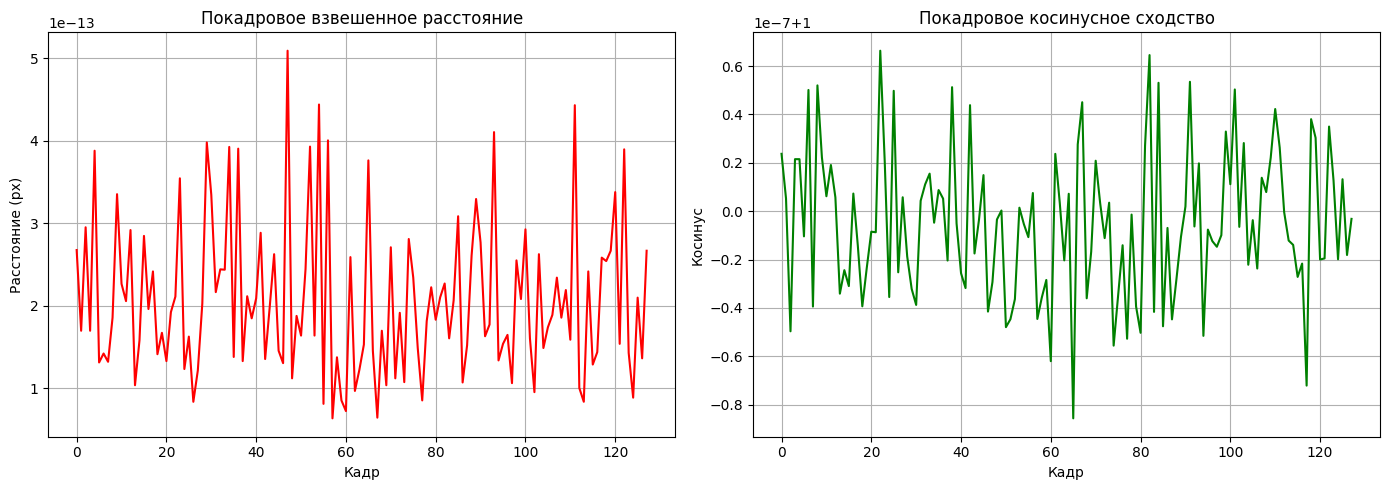

In [7]:
# Подготовка графика
valid_distances = [d if d is not None else 0 for d in distances]
valid_cosines = [c if c is not None else 0 for c in cos_distances]

plt.figure(figsize=(14, 5))

# Взвешенное расстояние
plt.subplot(1, 2, 1)
plt.plot(valid_distances, label="Weight Distance", color="red")
plt.title("Покадровое взвешенное расстояние")
plt.xlabel("Кадр")
plt.ylabel("Расстояние (px)")
plt.grid(True)

# Косинусное сходство
plt.subplot(1, 2, 2)
plt.plot(valid_cosines, label="Cosine Similarity", color="green")
plt.title("Покадровое косинусное сходство")
plt.xlabel("Кадр")
plt.ylabel("Косинус")
plt.grid(True)

plt.tight_layout()
plt.show()


### 📊 Результаты сравнения движений (анализ по видео)

#### 🔴 Взвешенное расстояние между позами (слева)

- Значения находятся на уровне `1e-13` — это практически ноль.
- Это означает, что позы совпадают **почти идеально** по координатам после выравнивания.
- Возможная причина — сравнивались **одинаковые или очень похожие видео**.

#### 🟢 Косинусное сходство (справа)

- Косинус стремится к `1`, что говорит о **сильной форме-сходимости**.
- Незначительные колебания объясняются шумом от модели и неидеальной съемкой.

---

### ✅ Вывод:

| Метрика                | Оценка                 |
|------------------------|------------------------|
| Взвешенное расстояние  | `≈ 0` (идеально)       |
| Косинусное сходство    | `≈ 1.0` (почти идеально) |

**Пользователь воспроизвёл движение практически идентично эталону.**

> 📌 Это может быть результатом сравнения одного и того же видео либо успешной имитации движения с очень высокой точностью.
